# 개요

**문제 접근**<br>
이번 대회에서 각 file 내의 이미지들은 별개의 정지된 pose가 아니라, 시간축에 따라 연속적으로 이어지는 action을 구성하고 있습니다. 따라서 각 file의 개별 이미지들을 따로 따로 학습하는 대신, 이미지 내에서 인간의 움직임에 따른 관절(keypoints) 좌표를 sequence 정보로 활용하여 time series 관점에서 접근하였습니다. 
<br><br>
**시도한 것들**<br>
처음에는 CNN으로 action의 개별 이미지를 학습하고 late fusion해주는 방법을 사용해봤는데 결과가 좋지 않았습니다. 또한 CNN으로 feature extraction 후 LSTM을 적용하는 방법도 사용했지만 큰 효과가 없었습니다. 가장 효과가 컸던 방법은 action에서 움직임에 따라 인간의 관절인 keypoints 좌표를 sequence 정보로 활용하여 LSTM 모델에서 학습하게끔 한 방법이었습니다. 다소 아쉬운 점은 제가 대회 막바지에 여유 시간이 없어서 모델 학습의 epochs를 극단적으로 줄이느라 학습 효과를 크게 보지 못했다는 점입니다. epochs를 많이 늘려서 학습하는 경우 훨씬 더 성능 향상을 기대해볼 수 있습니다. 이 부분에 대해서는 9번 섹션에서 더 설명하겠습니다.
<br><br>
**코드 구성**<br>
코드는 크게 4가지 파트로 이루어져 있습니다.  
1. **keypoints 분석** : 메타 데이터(json 파일)에 제공된 keypoints 정보를 활용하기 위하여, keypoints의 각 좌표가 신체의 어떤 부위를 의미하는지 시각화하여 분석
2. **keypoints features 전처리** : keypoints 좌표값을 바탕으로 특정 관절 부위간의 거리 계산 
3. **데이터 reshape** : LSTM 모델의 input shape에 맞춰서 데이터 reshape
4. **모델링** : Bidirectional LSTM 모델
<br><br>

# 1. colab 드라이브 마운트 및 라이브러리 임포트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Oct 18 13:20:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |    783MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold

from PIL import Image
import cv2
import glob
import matplotlib.pyplot as plt

import os
import time
from datetime import timedelta
import random
import json
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
pd.options.display.max_colwidth = None

# 2. 데이터 경로 설정 및 데이터셋 로드 

In [ ]:
! unzip -o -q "/content/drive/MyDrive/dacon/traffic.zip"

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

action_info = pd.read_csv('/content/action_information.csv')
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
#action_info 확인
action_info

,action,Label
0,우측에서 좌측으로,0
1,전방정지,1
2,전후방 동시정지,2
3,좌우측방 동시정지,3
4,좌측에서 우측으로,4
5,후방정지,5


# 3. keypoints 시각화

이번 대회에서는 각 이미지별 keypoints 정보가 메타데이터로 제공되고 있습니다. 각 keypoints가 어떤 부위에 해당하는지 구분하기 위하여, 이미지에 keypoints 좌표를 표시하고 bounding box로 crop하여 시각화하였습니다.<br>
c.f. 시각화 코드는 우주대마왕님의 draw_keypoints 코드를 참고하여 현 대회의 데이터에 맞게 변형해서 사용했습니다. https://dacon.io/competitions/official/235701/codeshare/2372?page=1&dtype=vote

In [ ]:
# 이미지에 keypoints를 표시하고 bounding box로 crop하는 함수 정의 
def display_bbox_with_keypoints(file_name:str, image_num:int)-> None:
  # path 
  image_paths = sorted(glob.glob(train_dir + f'/{file_name}/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
  json_path = glob.glob(train_dir + f'/{file_name}/*.json')[0]

  # bounding boxes
  js = json.load(open(json_path))
  bounding_boxes = js.get('sequence').get('bounding_box')
  bounding_boxes = [(float(a),float(b),float(c),float(d)) for a,b,c,d in bounding_boxes] 
  bounding_box = bounding_boxes[image_num]

  # keypoints
  pos_keypoints = js.get('sequence').get('2d_pos')
  keypoint_x = []
  keypoint_y = []
  keypoints = []

  for i in range(len(image_paths)):
    keypoint_x.append(list(map(float, pos_keypoints[i]))[::3])
    keypoint_y.append(list(map(float, pos_keypoints[i]))[1::3])

  for i in range(len(image_paths)):
    _temp = []
    for k in range(24):
      _temp.append([keypoint_x[i][k], keypoint_y[i][k]])
    keypoints.append(_temp)
    
  keypoints = np.array(keypoints)
  keypoints = keypoints[image_num].astype(np.int64)

  # load the image 
  image = cv2.imread(image_paths[image_num])

  # color 
  np.random.seed(42)
  colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(len(keypoints))}

  # draw keypoints on image
  for i, keypoint in enumerate(keypoints):
    cv2.circle(image, tuple(keypoint), 3, colors.get(i), thickness=3, lineType=cv2.FILLED)
    cv2.putText(image, str(i), tuple(keypoint), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)

  # crop bounding box 
  left = int(bounding_box[0])
  right = int(bounding_box[2]) 
  top = int(bounding_box[1])
  bottom = int(bounding_box[3])
  image = image[top:bottom, left:right, :]

  # display bounding box with keypoints
  fig, ax = plt.subplots(dpi=120)
  ax.imshow(image)
  ax.axis('off')
  plt.show()

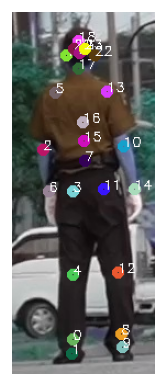

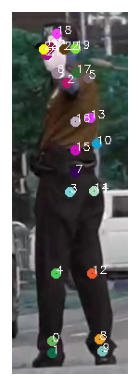

In [ ]:
display_bbox_with_keypoints('file_0', 0) # file_0의 1번째 이미지 
display_bbox_with_keypoints('file_0', 45) # file_0의 46번째 이미지 

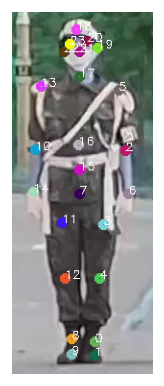

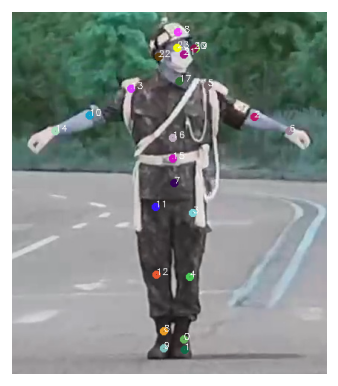

In [ ]:
display_bbox_with_keypoints('file_105', 0) # file_105의 1번째 이미지 
display_bbox_with_keypoints('file_105', 45) # file_105의 46번째 이미지 

임의의 이미지들을 시각화해본 결과, 제공된 keypoints가 각 신체 부위에 정확히 위치해있기 때문에 이 정보를 충분히 활용할 수 있다고 판단하였습니다. 제공된 keypoints는 각 이미지당 총 24개가 존재하였으며 각각 다음의 신체 부위에 대응됩니다.<br><br>

**0 : 'left_ankle'/ 1 : 'left_foot' / 2: 'left_elbow' / 3: 'left_hip' / 4: 'left_knee' / 5: 'left_shoulder' / 6: 'left_wrist' / 7: 'sacrum' / 8: 'right_ankle' / 9: 'right_foot' / 10: 'right_elbow' / 11: 'right_hip' / 
12: 'right_knee' / 13: 'right_shoulder' / 14: 'right_wrist' / 15: 'waist' / 16: 'back' / 17: 'neck' / 18: 'forehead' / 19: 'left_ear' / 20: 'left_eye' / 21: 'nose' / 22: 'right_ear' / 23: 'right_eye'**
<br><br>

이 중에서 1번 left_foot, 7번 sacrum, 9번 right_foot, 17번 neck, 18번 forehead, 20번 left_eye, 21번 nose, 23번 right_eye의 keypoints 정보는 다른 부위와 비슷한 위치에 있어 유의미한 정보를 도출하지 않는다고 판단하여 제거하였습니다.

# 4. keypoints 추출 및 데이터프레임 만들기

## 4-1. train_df 생성 

In [ ]:
# train 데이터에 대하여 keypoints 추출 및 데이터프레임 생성 
train_directories = np.array(sorted(glob.glob(train_dir + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))
train_df = pd.DataFrame()

for train_directory in tqdm(train_directories, total = len(train_directories)): 
  file_name = train_directory.split('/')[-1]
  
  # paths 
  image_paths = sorted(glob.glob(train_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
  json_path = glob.glob(train_directory + '/*.json')[0]

  # json info 
  js = json.load(open(json_path))

  # target
  target = js.get('action') 
  # file_33의 label annotation이 0으로 잘못되어 있기 때문에 이를 5로 수정 
  if file_name == 'file_33':
    target = 5

  # keypoints 
  pos_keypoints = js.get('sequence').get('2d_pos')
  keypoint_x = []
  keypoint_y = []
  keypoints = []

  # keypoint_x, keypoint_y
  for i in range(len(image_paths)):
    keypoint_x.append(list(map(float, pos_keypoints[i]))[::3])
    keypoint_y.append(list(map(float, pos_keypoints[i]))[1::3])
  
  drop_keypoints_num = [1, 7, 9, 14, 18, 20, 21, 23]  # 불필요한 keypoints 사용하지 않음 

  for i in range(len(image_paths)):
    _temp = []
    for k in range(24):
      if k in drop_keypoints_num:
        continue
      _temp.append([keypoint_x[i][k], keypoint_y[i][k]])
    keypoints.append(_temp)
  
  keypoints = np.array(keypoints) # 최종 keypoints 16개 

  # dataframe 
  _df = pd.DataFrame({'path' : image_paths, 
                      'file_name' : file_name,
                      'left_ear_x' : keypoints[:, 14, 0],
                      'left_ear_y' : keypoints[:, 14, 1],
                      'right_ear_x' : keypoints[:, 15, 0],
                      'right_ear_y' : keypoints[:, 15, 1],
                      'left_shoulder_x' : keypoints[:, 4, 0],
                      'left_shoulder_y' : keypoints[:, 4, 1],
                      'right_shoulder_x' : keypoints[:, 10, 0],
                      'right_shoulder_y' : keypoints[:, 10, 1],
                      'left_elbow_x' : keypoints[:, 1, 0],
                      'left_elbow_y' : keypoints[:, 1, 1],
                      'right_elbow_x' : keypoints[:, 7, 0],
                      'right_elbow_y' : keypoints[:, 7, 1],
                      'left_wrist_x' : keypoints[:, 5, 0],
                      'left_wrist_y' : keypoints[:, 5, 1],
                      'right_wrist_x' : keypoints[:, 11, 0],
                      'right_wrist_y' : keypoints[:, 11, 1],
                      'left_hip_x' :  keypoints[:, 2, 0],
                      'left_hip_y' :  keypoints[:, 2, 1],
                      'right_hip_x' :  keypoints[:, 8, 0],
                      'right_hip_y' :  keypoints[:, 8, 1],
                      'left_knee_x' : keypoints[:, 3, 0],
                      'left_knee_y' : keypoints[:, 3, 1],
                      'right_knee_x' : keypoints[:, 9, 0],
                      'right_knee_y' : keypoints[:, 9, 1],
                      'left_ankle_x' : keypoints[:, 0, 0],
                      'left_ankle_y' : keypoints[:, 0, 1],
                      'right_ankle_x' : keypoints[:, 6, 0],
                      'right_ankle_y' : keypoints[:, 6, 1],
                      'back_x' : keypoints[:, 13, 0],
                      'back_y' : keypoints[:, 13, 1],
                      'waist_x' : keypoints[:, 12, 0],
                      'waist_y' : keypoints[:, 12, 1],
                      'target' : target,
                      })
  
  train_df = pd.concat([train_df, _df])

train_df

100%|██████████| 142/142 [00:02<00:00, 60.91it/s]


,path,file_name,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,back_x,back_y,waist_x,waist_y,target
0,/content/train/file_0/0.jpg,file_0,2371.92,663.723,2397.76,663.723,2361.58,697.316,2408.74,696.024,2350.60,749.644,2423.60,746.414,2355.77,787.113,2387.42,741.892,2377.73,787.113,2405.51,785.175,2377.09,863.344,2418.43,861.406,2377.09,922.778,2421.66,917.610,2382.90,675.997,2386.13,724.449,5
1,/content/train/file_0/1.jpg,file_0,2369.48,663.777,2396.56,663.077,2361.58,695.521,2408.74,696.024,2348.02,750.290,2420.37,744.476,2352.54,786.467,2386.07,741.892,2374.59,788.010,2403.27,786.521,2375.15,862.052,2418.43,861.406,2374.51,922.778,2418.43,918.256,2382.45,679.586,2385.68,724.000,5
2,/content/train/file_0/2.jpg,file_0,2366.86,662.431,2395.03,661.519,2357.95,697.316,2405.11,696.024,2346.97,749.644,2419.97,746.414,2352.14,787.113,2383.79,741.892,2374.10,787.113,2401.88,785.175,2373.46,863.344,2414.80,861.406,2373.46,922.778,2418.03,917.610,2379.27,675.997,2382.50,724.449,5
3,/content/train/file_0/3.jpg,file_0,2363.64,661.534,2392.52,662.628,2357.09,695.970,2404.25,694.678,2344.32,749.644,2417.32,746.414,2346.80,787.562,2380.69,752.210,2371.45,787.562,2400.13,787.418,2370.81,863.344,2412.15,861.406,2370.81,922.778,2415.83,920.302,2379.31,684.072,2380.30,726.692,5
4,/content/train/file_0/4.jpg,file_0,2362.23,664.369,2388.07,664.369,2353.83,696.670,2405.51,696.024,2338.97,750.290,2413.91,749.644,2339.62,789.697,2379.67,745.122,2368.69,789.697,2397.76,789.697,2367.40,866.574,2408.74,864.636,2367.40,926.008,2411.97,920.840,2377.73,686.333,2380.32,727.033,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,/content/train/file_141/143.jpg,file_141,1940.70,979.115,1937.96,980.038,1958.05,1012.100,1923.26,1015.850,1955.75,1069.390,1920.62,1075.410,1931.89,1121.240,1939.14,1073.700,1957.53,1139.250,1936.15,1137.740,1957.77,1208.720,1945.34,1212.590,1965.84,1294.740,1951.80,1295.020,1938.79,994.812,1938.41,1048.130,5
144,/content/train/file_141/144.jpg,file_141,1940.70,979.115,1937.96,980.038,1958.05,1012.100,1923.26,1015.850,1955.75,1069.390,1920.62,1075.410,1931.89,1121.240,1939.14,1073.700,1957.53,1139.250,1936.15,1137.740,1957.77,1208.720,1945.34,1212.590,1965.84,1294.740,1951.80,1295.020,1938.79,994.812,1938.41,1048.130,5
145,/content/train/file_141/145.jpg,file_141,1940.70,979.115,1937.96,980.038,1958.05,1012.100,1923.26,1015.850,1955.75,1069.390,1920.62,1075.410,1931.89,1121.240,1939.14,1073.700,1957.53,1139.250,1936.15,1137.740,1957.77,1208.720,1945.34,1212.590,1965.84,1294.740,1951.80,1295.020,1938.79,994.812,1938.41,1048.130,5
146,/content/train/file_141/146.jpg,file_141,1940.70,979.115,1937.96,980.038,1958.05,1012.100,1923.26,1015.850,1955.75,1069.390,1920.62,1075.410,1931.89,1121.240,1939.14,1073.700,1957.53,1139.250,1936.15,1137.740,1957.77,1208.720,1945.34,1212.590,1965.84,1294.740,1951.80,1295.020,1938.79,994.812,1938.41,1048.130,5


In [ ]:
train_df.groupby('target')['file_name'].agg(['unique', 'nunique']).reset_index()

,target,unique,nunique
0,0,"[file_11, file_12, file_13, file_14, file_15, file_16, file_17, file_44, file_45, file_46, file_47, file_48, file_86, file_87, file_88, file_89, file_91, file_92, file_97, file_121, file_122, file_123, file_124]",23
1,1,"[file_23, file_24, file_25, file_26, file_27, file_28, file_29, file_30, file_55, file_56, file_57, file_58, file_59, file_81, file_100, file_111, file_112, file_113, file_114, file_119, file_120, file_138, file_139, file_140]",24
2,2,"[file_4, file_8, file_9, file_40, file_41, file_42, file_43, file_67, file_80, file_84, file_85, file_107, file_108, file_109, file_110, file_126, file_127, file_128, file_129, file_130, file_131, file_135, file_136, file_137]",24
3,3,"[file_1, file_2, file_3, file_7, file_10, file_37, file_38, file_39, file_62, file_63, file_64, file_65, file_66, file_76, file_77, file_78, file_79, file_103, file_104, file_105, file_106, file_125]",22
4,4,"[file_18, file_19, file_20, file_21, file_22, file_49, file_50, file_51, file_52, file_53, file_54, file_90, file_93, file_94, file_95, file_96, file_98, file_99, file_101, file_116, file_117, file_118, file_132, file_133]",24
5,5,"[file_0, file_5, file_6, file_31, file_32, file_33, file_34, file_35, file_36, file_60, file_61, file_68, file_69, file_70, file_71, file_72, file_73, file_74, file_75, file_82, file_83, file_102, file_115, file_134, file_141]",25


train 데이터에서 각 target별로 22~25개 파일로 구성되어 있습니다.

## 4-2. test_df 생성

In [ ]:
# test 데이터에 대하여 keypoints 추출 및 데이터프레임 생성
test_directories = np.array(sorted(glob.glob(test_dir + '/*'), key = lambda x : int(x.split('/')[-1].split('_')[-1])))
test_df = pd.DataFrame()

for test_directory in tqdm(test_directories, total = len(test_directories)): 
  file_name = test_directory.split('/')[-1]
  
  # paths 
  image_paths = sorted(glob.glob(test_directory + '/*.jpg'), key = lambda x : int(x.split('/')[-1].replace('.jpg','')))
  json_path = glob.glob(test_directory + '/*.json')[0]

  # json info 
  js = json.load(open(json_path))

  # keypoints 
  pos_keypoints = js.get('sequence').get('2d_pos')
  keypoint_x = []
  keypoint_y = []
  keypoints = []

  # keypoint_x, keypoint_y
  for i in range(len(image_paths)):
    keypoint_x.append(list(map(float, pos_keypoints[i]))[::3])
    keypoint_y.append(list(map(float, pos_keypoints[i]))[1::3])
  
  drop_keypoints_num = [1, 7, 9, 14, 18, 20, 21, 23] # 불필요한 keypoints 사용하지 않음 

  for i in range(len(image_paths)):
    _temp = []
    for k in range(24):
      if k in drop_keypoints_num:
        continue
      _temp.append([keypoint_x[i][k], keypoint_y[i][k]])
    keypoints.append(_temp)
  
  keypoints = np.array(keypoints) # 최종 keypoints 16개 

  # dataframe 
  _df = pd.DataFrame({'path' : image_paths, 
                      'file_name' : file_name,
                      'left_ear_x' : keypoints[:, 14, 0],
                      'left_ear_y' : keypoints[:, 14, 1],
                      'right_ear_x' : keypoints[:, 15, 0],
                      'right_ear_y' : keypoints[:, 15, 1],
                      'left_shoulder_x' : keypoints[:, 4, 0],
                      'left_shoulder_y' : keypoints[:, 4, 1],
                      'right_shoulder_x' : keypoints[:, 10, 0],
                      'right_shoulder_y' : keypoints[:, 10, 1],
                      'left_elbow_x' : keypoints[:, 1, 0],
                      'left_elbow_y' : keypoints[:, 1, 1],
                      'right_elbow_x' : keypoints[:, 7, 0],
                      'right_elbow_y' : keypoints[:, 7, 1],
                      'left_wrist_x' : keypoints[:, 5, 0],
                      'left_wrist_y' : keypoints[:, 5, 1],
                      'right_wrist_x' : keypoints[:, 11, 0],
                      'right_wrist_y' : keypoints[:, 11, 1],
                      'left_hip_x' :  keypoints[:, 2, 0],
                      'left_hip_y' :  keypoints[:, 2, 1],
                      'right_hip_x' :  keypoints[:, 8, 0],
                      'right_hip_y' :  keypoints[:, 8, 1],
                      'left_knee_x' : keypoints[:, 3, 0],
                      'left_knee_y' : keypoints[:, 3, 1],
                      'right_knee_x' : keypoints[:, 9, 0],
                      'right_knee_y' : keypoints[:, 9, 1],
                      'left_ankle_x' : keypoints[:, 0, 0],
                      'left_ankle_y' : keypoints[:, 0, 1],
                      'right_ankle_x' : keypoints[:, 6, 0],
                      'right_ankle_y' : keypoints[:, 6, 1],
                      'back_x' : keypoints[:, 13, 0],
                      'back_y' : keypoints[:, 13, 1],
                      'waist_x' : keypoints[:, 12, 0],
                      'waist_y' : keypoints[:, 12, 1],
                      })
  
  test_df = pd.concat([test_df, _df])

test_df

100%|██████████| 45/45 [00:00<00:00, 80.99it/s]


,path,file_name,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,back_x,back_y,waist_x,waist_y
0,/content/test/file_142/0.jpg,file_142,1714.97,1004.070,1717.21,1004.260,1721.51,1021.210,1718.33,1022.950,1720.58,1049.56,1720.89,1049.56,1712.79,1069.18,1714.66,1054.85,1723.38,1079.78,1723.07,1079.78,1719.95,1114.36,1720.58,1114.36,1725.56,1144.27,1725.87,1144.27,1715.90,1014.350,1714.85,1038.19
1,/content/test/file_142/1.jpg,file_142,1714.97,1004.070,1717.21,1004.260,1721.51,1024.950,1718.33,1022.950,1717.22,1049.93,1717.53,1050.31,1710.55,1069.18,1714.66,1054.85,1723.38,1079.78,1723.07,1079.78,1719.95,1114.36,1720.58,1114.36,1725.56,1144.27,1725.87,1144.27,1715.90,1014.350,1714.85,1038.19
2,/content/test/file_142/2.jpg,file_142,1714.97,1004.070,1717.21,1004.260,1719.95,1023.080,1718.33,1022.950,1717.22,1049.93,1717.53,1050.31,1710.55,1071.36,1714.66,1054.85,1723.38,1079.78,1723.07,1079.78,1719.95,1114.36,1720.58,1114.36,1725.56,1144.27,1725.87,1144.27,1715.90,1014.350,1714.85,1038.19
3,/content/test/file_142/3.jpg,file_142,1714.97,1004.070,1717.21,1004.260,1719.58,1024.580,1718.33,1022.950,1717.22,1049.93,1717.53,1050.31,1710.55,1071.36,1714.66,1054.85,1723.38,1079.78,1723.07,1079.78,1719.95,1114.36,1720.58,1114.36,1725.56,1144.27,1725.87,1144.27,1715.90,1014.350,1714.85,1038.19
4,/content/test/file_142/4.jpg,file_142,1714.97,1004.070,1717.21,1004.260,1719.58,1024.580,1718.33,1022.950,1717.22,1049.93,1717.53,1050.31,1710.55,1071.36,1714.66,1054.85,1723.38,1079.78,1723.07,1079.78,1719.95,1114.36,1720.58,1114.36,1725.56,1144.27,1725.87,1144.27,1715.90,1014.350,1714.85,1038.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,/content/test/file_186/164.jpg,file_186,1154.27,817.573,1156.16,817.687,1188.62,934.216,1182.55,936.448,1157.56,1131.69,1153.06,1134.51,1088.62,1245.60,1180.75,1168.41,1175.97,1285.34,1176.21,1285.85,1170.71,1489.32,1160.42,1489.84,1169.22,1748.88,1199.10,1742.79,1185.71,886.379,1182.30,1076.68
165,/content/test/file_186/165.jpg,file_186,1143.11,817.573,1145.00,817.687,1177.46,934.216,1171.39,936.448,1146.40,1131.69,1141.90,1134.51,1077.46,1245.60,1166.80,1170.27,1164.81,1294.64,1164.12,1292.36,1159.55,1504.20,1152.05,1500.07,1158.06,1748.88,1187.94,1742.79,1174.55,886.379,1171.14,1082.26
166,/content/test/file_186/166.jpg,file_186,1133.06,814.224,1134.95,814.338,1167.41,930.867,1161.34,933.099,1136.35,1128.34,1131.85,1131.16,1067.41,1242.25,1156.75,1166.92,1154.76,1291.29,1154.07,1289.01,1149.50,1500.85,1142.00,1496.72,1148.01,1750.00,1181.24,1741.67,1164.50,883.030,1161.09,1078.91
167,/content/test/file_186/167.jpg,file_186,1126.36,816.457,1128.25,816.571,1160.71,933.100,1154.64,935.332,1129.65,1130.57,1125.15,1133.39,1072.99,1245.60,1150.05,1169.15,1148.06,1293.52,1147.37,1291.24,1164.01,1507.55,1121.91,1509.00,1141.31,1752.23,1174.54,1743.90,1157.80,885.263,1154.39,1081.14


# 5. keypoints간의 거리 계산 


교통 수신호 동작에서 가장 중요한 keypoints은 elbow와 wrist 부위라고 볼 수 있습니다. 수신호 동작이니만큼 '팔과 손 부위의 위치가 어떻게 변하느냐'가 해당 동작을 구분하는 데에 중요한 요소라고 판단하였습니다. 따라서 각 시간축에 따라 다른 주요 신체 부위(shoulder, hip, ear)와 elblow, wrist간의 거리를 계산하면 팔과 손의 위치가 다른 부위 대비 비교적 얼마나 변하는지에 대한 정보를 얻을 수 있습니다. 즉 **수신호 동작을 수행하면서 팔과 손 부위가 다른 신체 부위와 얼마나 가까워지고 멀어지는지에 대한 상대적인 변화 정도**를 고려하기 위해 keypoints간의 거리를 계산하여 features로 추가해주었습니다.

In [ ]:
# 두 keypoints간의 거리 계산 함수 
def get_distance(df:pd.DataFrame, point1:str, point2:str, side:str)->float: 
  point1_x = f'{side}_{point1}_x'
  point1_y = f'{side}_{point1}_y'

  point2_x = f'{side}_{point2}_x'
  point2_y = f'{side}_{point2}_y'

  dist = np.sqrt((df[point1_x] - df[point2_x]) ** 2 + (df[point1_y] - df[point2_y]) ** 2)

  return dist

In [ ]:
# 데이터프레임에 두 keypoints간의 거리 feature 추가 함수 
def add_distance_features(df:pd.DataFrame, point1:str, point2:str, side:str)->pd.DataFrame:
  df[f'{side}_{point1}_{point2}_dist'] = df.apply(lambda x: get_distance(x, point1, point2, side), axis=1)
  return df

In [ ]:
# 두 keypoints간의 거리 계산하여 features로 추가 
keypoints_comb = [('shoulder', 'elbow'), ('shoulder', 'wrist'), ('elbow', 'wrist'), ('hip', 'elbow'), ('hip', 'wrist'), ('ear', 'elbow'), ('ear', 'wrist')]
                  
for (point1, point2) in tqdm(keypoints_comb):
  for side in ['left', 'right']:
    train_df = add_distance_features(train_df, point1, point2, side)
    test_df = add_distance_features(test_df, point1, point2, side)

display(train_df.shape, test_df.shape)

100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


(22218, 49)

(7020, 48)

# 6. keypoints 좌표값 제거 

주요 keypoints 간의 상대적인 거리를 계산해서 features로 추가해주었기 때문에 keypoints의 절대적인 좌표값은 불필요하다고 판단하여 제거해주었습니다.  

In [ ]:
# keypoints 좌표값 제거 
coords_col = train_df.iloc[:, 2:34].columns

train_df = train_df.drop(columns = coords_col)
test_df = test_df.drop(columns = coords_col)

display(train_df.shape, test_df.shape)

(22218, 17)

(7020, 16)

# 7. LSTM 모델 input shape에 맞춰서 데이터 reshape

각 file은 하나의 수신호 동작을 보여주는 동영상으로 간주할 수 있으며, 각 file에 들어간 이미지들이 동영상을 구성하는 프레임이라고 볼 수 있습니다. 이 때, LSTM 모델에서 각 프레임의 정보를 time step으로 하여 학습할 수 있도록 모든 file별로 이미지(프레임) 개수가 같게끔 reshape해주었습니다. 

예를 들어 file별 이미지 개수가 가장 적은 경우가 141개였고 가장 많은 경우가 194개였는데 가장 적은 경우인 141개 프레임에 맞춰서 그 개수를 초과하는 프레임을 가진 경우에는 뒷부분을 절삭해주었습니다. 절삭 시 뒷부분을 선택한 이유는, 각 file별로 완성된 동작이 2회 이상씩 반복되고 있었기 때문에 뒷부분 프레임을 조금 자르더라도 앞에서 완성된 동작을 학습할 수 있을 것이라는 판단 하에 진행하였습니다. 


In [ ]:
# 변수 설정 
N_TRAIN_FILE = train_df['file_name'].nunique()  # train의 전체 file 개수 (142개)
N_TEST_FILE = test_df['file_name'].nunique() # test의 전체 file 개수 (45개)
MAX_IMAGES_PER_FILE = train_df['file_name'].value_counts().min() # file별 이미지(프레임) 개수 최솟값 (141개)
N_FEATURES = train_df.drop(columns=['path', 'target', 'file_name']).shape[1] # features 개수 (14개)

In [ ]:
# train 데이터 reshape 
X = np.zeros((1, N_TRAIN_FILE, MAX_IMAGES_PER_FILE, N_FEATURES))
y = []

for num, file in enumerate(list(train_df['file_name'].unique())):
  _df = train_df.loc[train_df['file_name'] == file]

  # 각 파일별로 프레임 개수가 같아야 하기 때문에 가장 프레임 개수가 적은 파일 기준으로 길이를 맞춰줌 
  if _df.shape[0] > MAX_IMAGES_PER_FILE:
    _df = _df.drop(_df.index[MAX_IMAGES_PER_FILE:])

  features = np.array(_df.drop(columns = ['path', 'target', 'file_name']))
  label = int(_df['target'].unique()[0])

  X[0][num][:, :] = features
  y.append(label)

y = np.array(y)
print(X.shape, y.shape) # X.shape : (1, N_TRAIN_FILE, MAX_IMAGES_PER_FILE, N_FEATURES), y.shape : (N_TRAIN_FILE, )

(1, 142, 141, 14) (142,)


In [ ]:
# test 데이터 reshape
X_test = np.zeros((1, N_TEST_FILE, MAX_IMAGES_PER_FILE, N_FEATURES))

for num, file in enumerate(list(test_df['file_name'].unique())):
  _df = test_df.loc[test_df['file_name'] == file]

  # 각 파일별로 프레임 개수가 같아야 하기 때문에 가장 프레임 개수가 적은 파일 기준으로 길이를 맞춰줌 
  if _df.shape[0] > MAX_IMAGES_PER_FILE:
    _df = _df.drop(_df.index[MAX_IMAGES_PER_FILE:])

  features = np.array(_df.drop(columns = ['path', 'file_name']))

  X_test[0][num][:, :] = features

print(X_test.shape) # X.shape : (1, N_TEST_FILE, MAX_IMAGES_PER_FILE, N_FEATURES), y.shape : (N_TEST_FILE, )

(1, 45, 141, 14)


# 8. Bidirectional LSTM 모델링

Bidirectional LSTM 모델을 사용한 이유는, 시간축의 양방향으로 학습하여 이전 동작의 정보와 이후 동작의 정보를 모두 고려할 수 있게끔 하기 위함입니다.

또한 StratifiedKFold를 사용하여 4개의 validation fold sets으로 나누었고 for loop를 통해 각 fold set에 대하여 모델링을 적용하여, 각각 다른 데이터 구성으로 총 4번의 학습과 추론 결과를 블렌딩 앙상블해주는 효과를 얻었습니다. n_splits=4, epochs = 200, patience = 20으로 설정했을 때 모델 학습 및 inference까지 총 소요 시간은 Tesla P100 기준으로 약 2분 소요되었습니다.

In [ ]:
# 하이퍼 파라미터 및 변수 설정 
N_FOLD = 4
SEED = 42
N_CLASS = train_df['target'].nunique()
PATIENCE = 20
EPOCHS = 200

# SEED 고정 
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
skf = StratifiedKFold(n_splits = N_FOLD, shuffle = True, random_state = SEED)

In [ ]:
# model 정의 
def get_model(input_shape:tuple)->tf.keras.models.Model:
  inputs = Input(shape = input_shape)
  x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(inputs)
  x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2))(x)
  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = GlobalAveragePooling1D()(x)
  outputs = Dense(N_CLASS, activation='softmax')(x)
  model = Model(inputs, outputs)
  
  return model

In [ ]:
X_test = tf.squeeze(X_test) 
score_list = [] # validation loss score 
pred = np.zeros((X_test.shape[0], N_CLASS)) # 예측 결과 
start_time = time.time() 

# k-fold cross validation 
for i, (train_file, valid_file) in enumerate(skf.split(tf.reshape(X, [N_TRAIN_FILE, -1]), y)):
  print(f'Fold {i}')
  X_train, X_valid = tf.convert_to_tensor(X[0][train_file]), tf.convert_to_tensor(X[0][valid_file])
  y_train, y_valid = tf.expand_dims(y[train_file], axis=1), tf.expand_dims(y[valid_file], axis=1)
  

  # model 정의
  model = get_model((X_train.shape[1], X_train.shape[2]))

  # model loss, optimizer, metrics
  optimizer = tf.keras.optimizers.RMSprop(lr=1e-3, decay = 1e-4)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

  # early stopping 
  es = EarlyStopping(monitor = 'val_loss',
                      patience = PATIENCE, 
                      verbose = 1)

  # model checkpoint 
  checkpoint_path = 'my_checkpoint.ckpt'
  mc = ModelCheckpoint(filepath = checkpoint_path, 
                        monitor = 'val_loss', 
                        save_weights_only = True, 
                        save_best_only = True, 
                        verbose = 0)

  # model 학습 
  history = model.fit(x=X_train, y=y_train, 
                      validation_data = (X_valid, y_valid), 
                      epochs = EPOCHS, 
                      callbacks = [es, mc],
                      verbose = 0,
                      )
  
  # best weights 로드 및 모델 저장 
  model.load_weights(checkpoint_path)
  model.save(f'model{i}.h5')

  # best validation loss 저장 
  score_list.append(np.min(history.history['val_loss']))

  # model 예측 
  pred += model.predict(X_test) / N_FOLD
  print('=' * 80)

elapsed = time.time() - start_time
print(f'total elapsed time : {str(timedelta(seconds=elapsed))}')

Fold 0
Epoch 00063: early stopping
Fold 1
Epoch 00042: early stopping
Fold 2
Epoch 00055: early stopping
Fold 3
Epoch 00091: early stopping
total elapsed time : 0:01:51.156216


In [ ]:
best_score = np.mean(score_list)
print(score_list)
print(best_score)

[0.6004924774169922, 0.6617683172225952, 0.4425593912601471, 0.20940011739730835]
0.4785550758242607


# 9. 모델 학습의 epochs와 StratifiedKFold의 n_splits, EarlyStopping의 patience 조절

위의 1~8번 부분까지가 제출 코드이고, 아래 부록 부분은 참고적으로 epochs와 n_splits, patience 값을 늘려줄 시에 해당 모델에서 성능 향상이 된다는 사실을 덧붙이는 부분입니다. <br>
대회 참여 시에는 StratifiedKFold의 n_splits와  모델 학습의 epochs, EarlyStopping의 patience를 작은 값(n_splits = 4, epochs = 200, patience = 20)으로 설정했었는데, 이후에 epochs = 5000, patience = 300으로 설정하고 n_splits=8으로 하여 총 8번의 for loop로 추론 결과를 블렌딩한 결과, validation loss를 0.11대까지로 결과를 향상시킬 수 있었습니다. 이렇게 epochs, n_splits, patience를 늘린 경우 모델 학습 및 inference까지 총 소요 시간은 Tesla P100 기준으로 약 22분 소요되었습니다.

In [ ]:
# N_FOLD, PATIENCE, EPOCHS 늘려주기
N_FOLD = 8
PATIENCE = 300
EPOCHS = 5000

skf = StratifiedKFold(n_splits = N_FOLD, shuffle = True, random_state = SEED)

In [ ]:
X_test = tf.squeeze(X_test) 
score_list = [] # validation loss score 
pred = np.zeros((X_test.shape[0], N_CLASS)) # 예측 결과 
start_time = time.time() 

# k-fold cross validation 
for i, (train_file, valid_file) in enumerate(skf.split(tf.reshape(X, [N_TRAIN_FILE, -1]), y)):
  print(f'Fold {i}')
  X_train, X_valid = tf.convert_to_tensor(X[0][train_file]), tf.convert_to_tensor(X[0][valid_file])
  y_train, y_valid = tf.expand_dims(y[train_file], axis=1), tf.expand_dims(y[valid_file], axis=1)
  

  # model 정의
  model = get_model((X_train.shape[1], X_train.shape[2]))

  # model loss, optimizer, metrics
  optimizer = tf.keras.optimizers.RMSprop(lr=1e-3, decay = 1e-4)
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

  # early stopping 
  es = EarlyStopping(monitor = 'val_loss',
                      patience = PATIENCE, 
                      verbose = 1)

  # model checkpoint 
  checkpoint_path = 'my_checkpoint.ckpt'
  mc = ModelCheckpoint(filepath = checkpoint_path, 
                        monitor = 'val_loss', 
                        save_weights_only = True, 
                        save_best_only = True, 
                        verbose = 0)

  # model 학습 
  history = model.fit(x=X_train, y=y_train, 
                      validation_data = (X_valid, y_valid), 
                      epochs = EPOCHS, 
                      callbacks = [es, mc],
                      verbose = 0,
                      )
  
  # best weights 로드 및 모델 저장 
  model.load_weights(checkpoint_path)
  model.save(f'model{i}.h5')

  # best validation loss 저장 
  score_list.append(np.min(history.history['val_loss']))

  # model 예측 
  pred += model.predict(X_test) / N_FOLD
  print('=' * 80)

elapsed = time.time() - start_time
print(f'total elapsed time : {str(timedelta(seconds=elapsed))}')

Fold 0
Epoch 00744: early stopping
Fold 1
Epoch 00465: early stopping
Fold 2
Epoch 00414: early stopping
Fold 3
Epoch 00884: early stopping
Fold 4
Epoch 00580: early stopping
Fold 5
Epoch 00855: early stopping
Fold 6
Epoch 01001: early stopping
Fold 7
Epoch 01015: early stopping
total elapsed time : 0:21:55.381415


In [ ]:
best_score = np.mean(score_list)
print(score_list)
print(best_score)

[0.002103799721226096, 0.40572258830070496, 0.4000280499458313, 0.01925477385520935, 0.033454492688179016, 0.0008043093839660287, 0.0037640577647835016, 7.016682502580807e-05]
0.10815027981061576


In [ ]:
sub.iloc[:, 1:] = pred
sub

,file_path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5
0,./test\file_142,0.000213,0.000386,0.997868,0.000701,0.000122,0.000710
1,./test\file_143,0.000179,0.000404,0.010520,0.000031,0.000314,0.988552
2,./test\file_144,0.000540,0.001074,0.032150,0.966016,0.000155,0.000064
3,./test\file_145,0.001850,0.005244,0.982697,0.008871,0.000427,0.000910
4,./test\file_146,0.994520,0.004246,0.000534,0.000431,0.000183,0.000086
5,./test\file_147,0.995498,0.003283,0.000459,0.000502,0.000184,0.000075
6,./test\file_148,0.996958,0.002476,0.000183,0.000168,0.000123,0.000092
7,./test\file_149,0.000035,0.000034,0.000030,0.000161,0.999593,0.000147
8,./test\file_150,0.000677,0.998969,0.000085,0.000125,0.000062,0.000082
9,./test\file_151,0.000131,0.000423,0.000175,0.000230,0.000715,0.998327


In [ ]:
sub.to_csv('submission.csv', index = False)